In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

Install Tensorflow Addons: [LINK](https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/image_ops.ipynb#scrollTo=o_QTX_vHGbj7)

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.4 MB/s 


In [3]:
import os
import sys

from google.colab import drive 
drive.mount("/content/drive/", force_remount=True) 
colab_path = ("/content/drive/My Drive/colab/final_project/")
sys.path.append(colab_path)

IMG_PATH = "/content/drive/My Drive/colab/final_project/data/images"

Mounted at /content/drive/


In [4]:
import glob

# this doesn't work if the images are shared with you but keras can still 
# load them
glob.glob(IMG_PATH + "/*.jpg")

[]

Code and Concept Mostly based on: https://keras.io/examples/vision/mlp_image_classification/#build-a-classification-model

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

In [6]:
class Patches(layers.Layer):
    """
    https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

    For an image, extract square 'patches' of pixels in regular, deterministic
    pattern. 

    Note that patch extraction has no learnable parameters, so it is not a
    dynamic part of the network. 
    """
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [7]:
class FNetLayer(layers.Layer):
    """
    https://arxiv.org/abs/2105.03824

    FNet: Mixing Tokens with Fourier Transforms

    We show that Transformer encoder architectures can be sped up, with 
    limited accuracy costs, by replacing the self-attention sublayers 
    with simple linear transformations that "mix" input tokens.

    ...

    FNet has a light memory footprint and is particularly efficient at 
    smaller model sizes; for a fixed speed and accuracy budget, 
    small FNet models outperform Transformer counterparts.
    """
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [ 
                # RELU works better than GELU
                layers.Dense(units=embedding_dim, activation='relu'),
                # tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # extract features using convolution
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )

        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

>To avoid biasing the annotation for easily classifiable cell images, separate classes were included for artefacts, cells that could not be identified, and other cells belonging to morphological classes not represented in the scheme. From the annotated regions, 250 x 250-pixel images were extracted containing the respective annotated cell as a main content in the patch center (Figure 1A). No further cropping, filtering, or segmentation between foreground and background took place, leaving the algorithm with the task of identifying the main image content relevant for the respective annotation.

- Matek, Krappe, et. al pp. 1918, "Highly accurate differentiation of bone marrow cell
morphologies using deep neural networks on a large image
data set"

In [8]:
# Properties of our dataset
IMG_DIM = 128
IMAGE_SHAPE = (IMG_DIM, IMG_DIM, 3)

# get all the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_PATH,
    label_mode='categorical',
    validation_split=0.8,
    subset="training",
    seed=1337,
    image_size=(IMG_DIM, IMG_DIM),
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_PATH,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1337,
    image_size=(IMG_DIM, IMG_DIM),
)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 171374 files belonging to 21 classes.
Using 34275 files for training.
Found 171374 files belonging to 21 classes.
Using 34274 files for validation.


In [17]:
# Size of the patches in pixels be extracted from convolved features
# ~0.25 of side length worked well with 32x32
PATCH_SIZE = 8

# Number of FNET blocks
# More blocks greatly decreases training time
NUM_BLOCKS = 4

# Number of hidden units in each FNET block
HIDDEN_SIZE = 256
NUM_CLASSES = 21

# def build_model(input_shape, num_classes, patch_size=8, num_blocks=4, dropout_rate=0.2, embedding_dim=256):
#     # single image dimensions
#     width, height, channels = input_shape
#     inputs = layers.Input(shape=input_shape)
#     num_strides = 2

#     # image transformations
#     data_augmentation = tf.keras.Sequential(
#       [
#           tf.keras.layers.Rescaling(1./255),
#           tf.keras.layers.RandomFlip("horizontal"),
#           tf.keras.layers.RandomZoom(
#               height_factor=0.2, width_factor=0.2
#           ),
#           # we expect these to rotate a lot, how do you know
#           # which is the 'bottom' of a cell?
#           tf.keras.layers.RandomRotation(
#               factor=(-0.7, 0.6)
#           ),
#       ],
#     )

#     # add data augmentation
#     inputs = data_augmentation(inputs)

#     # Convolution layers
#     x = tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation='relu', padding='same')(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(.3)(x)

#     # --- stride layers ---
#     x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(.1)(x)

#     # x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)

#     x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(.1)(x)
#     # -------

#     # x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
#     # x = tf.keras.layers.BatchNormalization()(x)
#     # x = tf.keras.layers.Dropout(.1)(x)
    
#     # larger convolutions once image is smaller
#     x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(.1)(x)

#     x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(.1)(x)

#     # number of patches depends on desired size of path relative to
#     # image AFTER convolution is applied
#     # num_strides = 0
#     num_patches = ((width//2**num_strides) // patch_size) ** 2  

#     # Create patches.
#     patches = Patches(patch_size, num_patches)(x)

#     # Convolve the patches a few times
#     patches = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(patches)
#     patches = tf.keras.layers.BatchNormalization()(patches)
#     patches = tf.keras.layers.Dropout(.1)(patches)
#     patches = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(patches)

#     # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
#     x = layers.Dense(units=embedding_dim)(patches)

#     # use positional encoding for FNet
#     positions = tf.range(start=0, limit=num_patches, delta=1)
#     position_embedding = layers.Embedding(
#         input_dim=num_patches, output_dim=embedding_dim
#     )(positions)
#     x = x + position_embedding
    
#     # Process patches using n FNets
#     fnet_blocks = keras.Sequential(
#         [
#             FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)
#         ]
#     )
#     x = fnet_blocks(x)

#     # Apply global average pooling to generate a [batch_size, embedding_dim] 
#     # representation tensor.
#     representation = layers.GlobalAveragePooling1D()(x)
    
#     # Apply dropout.
#     representation = layers.Dropout(rate=dropout_rate)(representation)
    
#     # Compute logits outputs.
#     logits = layers.Dense(num_classes, activation='softmax')(representation)

#     # Create the Keras model.
#     return keras.Model(inputs=inputs, outputs=logits)
def build_model(input_shape, num_classes, patch_size=8, num_blocks=4, dropout_rate=0.2, embedding_dim=256):
    # single image dimensions
    width, height, channels = input_shape
    inputs = layers.Input(shape=input_shape)
    num_strides = 2

    data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.Normalization(),
          tf.keras.layers.RandomFlip("horizontal"),
          tf.keras.layers.RandomZoom(
              height_factor=0.2, width_factor=0.2
          ),
      ],
    )

    # Convolution layers
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(.3)(x)

    # --- stride layers ---
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(.1)(x)

    # x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(.1)(x)
    # -------

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(.1)(x)
    

    # larger convolutions once image is smaller
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(.1)(x)

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(.1)(x)

    # number of patches depends on desired size of path relative to
    # image AFTER convolution is applied
    num_patches = ((width//2**num_strides) // patch_size) ** 2  

    # Create patches.
    patches = Patches(patch_size, num_patches)(x)

    # patches = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(patches)
    # patches = tf.keras.layers.BatchNormalization()(patches)
    # patches = tf.keras.layers.Dropout(.1)(patches)
    # patches = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(patches)

    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)

    # use positional encoding for FNet
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=embedding_dim
    )(positions)
    x = x + position_embedding
    
    # Process patches using n FNets
    fnet_blocks = keras.Sequential(
        [
            FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)
        ]
    )
    x = fnet_blocks(x)

    # Apply global average pooling to generate a [batch_size, embedding_dim] 
    # representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    
    # Compute logits outputs.
    logits = layers.Dense(num_classes, activation='softmax')(representation)

    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


model = build_model(
    input_shape=IMAGE_SHAPE, 
    num_classes=NUM_CLASSES, 
    patch_size=PATCH_SIZE, 
    num_blocks=NUM_BLOCKS, 
    embedding_dim=HIDDEN_SIZE
)
model.summary()

MODEL_PERFORMANCE_METRICS = [
    # make sure your classes are one-hot encoded
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    # precision recall curve
    tf.keras.metrics.AUC(name='prc', curve='PR'), 
]

model.compile(
    # default configuration adam works better than weighted decay adam
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=MODEL_PERFORMANCE_METRICS,
)

history = model.fit(
    train_ds,
    batch_size=1500,
    epochs = 20,
    validation_steps=500,
    validation_data=val_ds
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 batch_normalization_43 (Bat  (None, 128, 128, 8)      32        
 chNormalization)                                                
                                                                 
 dropout_73 (Dropout)        (None, 128, 128, 8)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        4672      
                                                                 
 batch_normalization_44 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                          

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1072/1072 [==============================] - 403s 372ms/step - loss: 1.6613 - accuracy: 0.4778 - precision: 0.6869 - recall: 0.2999 - auc: 0.9197 - prc: 0.4997 - val_loss: 1.8360 - val_accuracy: 0.4497 - val_precision: 0.6142 - val_recall: 0.3461 - val_auc: 0.9009 - val_prc: 0.4750
Epoch 2/20
1072/1072 [==============================] - 40s 37ms/step - loss: 1.2340 - accuracy: 0.6118 - precision: 0.7520 - recall: 0.4858 - auc: 0.9545 - prc: 0.6705 - val_loss: 1.9495 - val_accuracy: 0.4261 - val_precision: 0.5456 - val_recall: 0.3019 - val_auc: 0.8890 - val_prc: 0.4085
Epoch 3/20
1072/1072 [==============================] - 40s 37ms/step - loss: 1.0852 - accuracy: 0.6583 - precision: 0.7777 - recall: 0.5500 - auc: 0.9644 - prc: 0.7276 - val_loss: 1.3236 - val_accuracy: 0.5860 - val_precision: 0.7226 - val_recall: 0.4728 - val_auc: 0.9482 - val_prc: 0.6447
Epoch 4/20
1072/1072 [==============================] - 40s 37ms/step - loss: 0.9895 - accuracy: 0.6890 - precision: 0.7929 - recall:

In [9]:
# model.save('/tmp/model_20_epochs')
model = tf.keras.models.load_model('/tmp/model_20_epochs')

In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])


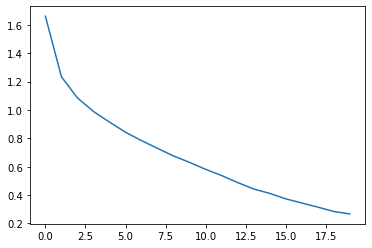

In [23]:
plt.plot(history.history['loss'])

In [10]:
from google.colab import files


# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('PPCF - Accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# PRC
plt.plot(history.history['prc'])
plt.plot(history.history['val_prc'])
plt.title('PPCF - Precision-Recall Curve')
plt.ylabel('PRC')
plt.xlabel('epoch')
plt.legend(['train PRC', 'test PRC'], loc='upper left')
plt.savefig('ppcf_prc.png', dpi=1200)
files.download("ppcf_prc.png") 

NameError: ignored

In [29]:

# Precision / Recall
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('PPCF - Precision / Recall')
plt.ylabel('precision / recall')
plt.xlabel('epoch')
plt.legend(['train precision', 'test precision', 'train recall', 'test recall'], loc='upper left')
# plt.show()
plt.savefig('my_fig.png', dpi=1200)
files.download("my_fig.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [11]:
y_pred = model.predict(val_ds)

1072/1072 [==============================] - 364s 337ms/step


In [12]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [13]:
y_pred.shape

(34274, 21)

In [14]:
y_true.shape

(34274, 21)

In [78]:
from sklearn.metrics import classification_report

In [91]:
report = classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1), output_dict=True)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
import pandas as pd




In [ ]:
CLASSNAME_LOOKUP = {
        'ABE': 'Abnormal eosinophil',
        'ART': 'Artefact',
        'BAS': 'Basophil',
        'BLA': 'Blast',
        'EBO': 'Erythroblast',
        'EOS': 'Eosinophil',
        'FGC': 'Faggott cell',
        'HAC': 'Hairy cell',
        'KSC': 'Smudge cell',
        'LYI': 'Immature lymphocyte',
        'LYT': 'Lymphocyte',
        'MMZ': 'Metamyelocyte',
        'MON': 'Monocyte',
        'MYB': 'Myelocyte',
        'NGB': 'Band neutrophil',
        'NGS': 'Segmented neutrophil',
        'NIF': 'Not identifiable',
        'OTH': 'Other cell',
        'PEB': 'Proerythroblast',
        'PLM': 'Plasma cell',
        'PMO': 'Promyelocyte',
    }

In [99]:
report_fixed = {len(k) <= 2 and list(CLASSNAME_LOOKUP.keys())[int(k)] or k: v for k, v in report.items()}

In [102]:
df = pd.DataFrame(report_fixed)
df = df.transpose().round(2)

In [105]:
df.to_csv('precision_recall_report.csv')
!cp precision_recall_report.csv "drive/My Drive/"

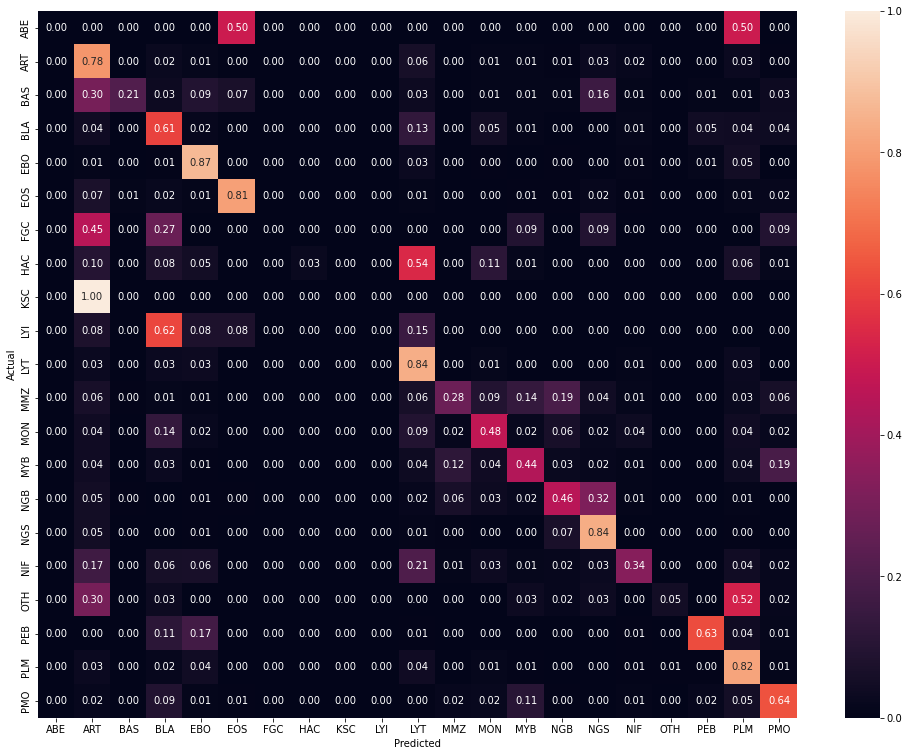

In [70]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true.argmax(axis=-1), y_pred.argmax(axis=-1), )

cm = np.around(cm, decimals=2)

names = list(CLASSNAME_LOOKUP.keys())

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(17,13))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=names, yticklabels=names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [71]:
fig.savefig('my_fig.png', dpi=300)
files.download("my_fig.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None))>

In [54]:
import seaborn as sn